# HiPPO Matrices
---

## Load Packages

In [1]:
!pip install numpy --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 55.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cupy-cuda11x 11.0.0 requires numpy<1.26,>=1.20, but you have numpy 1.26.0 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.26.0 which is incompatible.
tensorflow 2.13.0 requires numpy<=1.24.3,>=1.22, but you have numpy 1.26.0 which is incompatible.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import math
from scipy import linalg as la
from scipy import signal
from scipy import special as ss
import torch
from torchvision import datasets
from torchvision import transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"The Device: {device}")

The Device: cuda


### Hippo NN Module

In [2]:
class HIPPO_LEGS(nn.Module):
    """Hippo class utilizing legs polynomial"""

    def __init__(self, N, gbt_alpha = 0.5, maxlength = 1024):
        super(HIPPO_LEGS, self).__init__()
        self.N = N
        self.gbt_alpha = gbt_alpha
        self.maxlength = maxlength

    def compute_A(self, n, k):
        '''
        Computes the values for the HiPPO A matrix row by column
        using the piecewise equation on p. 31 eq. 29:
                (2n+1)^{1/2} (2k+ 1)^{1/2} if n > k
        A_{nk} = n+1                       if n = k,
                 0                         if n < k
        , where n represents the row and k the columns.

        Input:
            n (int):
                nth row of a square matrix of size N
            k (int):
                kth column of a square matrix of size N

        Output:
            Values (float):
            Individual values for the elements in the A matrix.
        '''
        if n > k:
            val = np.sqrt(2 * n + 1, dtype = np.float32) * np.sqrt(2 * k + 1, dtype = np.float32)
        if n == k:
            val = n + 1
        if n < k:
            val = 0
        return val

    def compute_B(self, n):
        '''
        Computes the values for the HiPPO B matrix row by column
        using the piecewise equation on p. 31 eq. 29:
        B_{n} = (2n+1)^{1/2}

        Input:
            n (int):
                nth column of a square matrix of size N.

        Output:
            Values (float):
            Individual values for the elements in the B matrix.
            The next hidden state (aka coefficients representing the function, f(t))
        '''
        val = np.sqrt(2 * n + 1, dtype = np.float32)
        return val

    def get_A_and_B(self, N):
        '''
        Creates the HiPPO A and B matrix given the size N along a single axis of
        a square matrix.

        Input:
            N (int):
            Size N of a square matrix along a single axis.

        Output:
            A (np.ndarray)
                shape: (N,N)
                the HiPPO A matrix.
            B (np.ndarray)
                shape: (N,):
                The HiPPO B matrix.
        '''
        A = np.zeros((self.N, self.N), dtype = np.float32)
        B = np.zeros((self.N, 1), dtype = np.float32)
        for n in range(A.shape[0]):
            B[n][0] = self.compute_B(n = n)
            for k in range(A.shape[1]):
                A[n, k] = self.compute_A(n = n , k = k)
        return A  * -1, B

    def generalized_bilinear_transform(self, A, B, t, gbt_alpha):
        '''
        Performs the generalised bilinaer transform from p. 21 eq.13:
        c(t + ∆t) − ∆tαAc(t + ∆t) = (I + ∆t(1 − α)A)c(t) + ∆tBf(t)
        c(t + ∆t) = (I − ∆tαA)^{−1} (I + ∆t(1 − α)A)c(t) + ∆t(I − ∆tαA)^{−1}Bf(t).
        on the HiPPO matrix A and B, transforming them.
        Input:
            A (np.ndarray):
                shape: (N, N)
                the HiPPO A matrix
            B (np.ndarray):
                shape: (N,)
                the HiPPO B matrix
            Timestep t = 1/input length at t (int):

        Output:
            GBTA (np.array):
                shape: (N, N)
                Transformed HiPPO A matrix.

            GBTB (np.array):
                shape: (N,)
                Transformed HiPPO B matrix.
        '''
        I = np.eye(A.shape[0], dtype = np.float32)
        delta_t = 1 / t
        EQ13_p1 = I - (delta_t * gbt_alpha * A)
        EQ13_p2 = I + (delta_t * (1 - gbt_alpha) * A)
        EQA = np.linalg.solve(EQ13_p1, EQ13_p2)
        EQB =  np.linalg.solve(EQ13_p1, (delta_t * B))
        return EQA, EQB

    def get_stacked_GBT(self):
        A, B = self.get_A_and_B(self.N)
        GBTA_stacked = np.empty((self.maxlength, self.N, self.N), dtype=np.float32)
        GBTB_stacked = np.empty((self.maxlength, self.N, 1), dtype=np.float32)
        for t in range(1, self.maxlength + 1):
            GBTA, GBTB = self.generalized_bilinear_transform(A = A, B = B, t = t, gbt_alpha = self.gbt_alpha)
            GBTA_stacked[t-1] = GBTA
            GBTB_stacked[t-1] = GBTB
        return GBTA_stacked, GBTB_stacked

    def discrete_hippo_operator(self, A, B, inputs, c_t =  None):
        '''
        Input:
            A (np.ndarray):
                shape: (N, N)
                the discretized A matrix
            B (np.ndarray):
                shape: (N, 1)
                the discretized B matrix
            c_t (np.ndarray):
                shape: (batch size, input length, N)
                the initial hidden state
            inputs (torch.tensor):
                shape: (batch size, maxlength)
                the input sequence
        Output:
            c (np.array):
                shape: (maxlength, batchsize, 1, N)
                coefficent matrix c that represent the input f or signal u at every timestep t.
        '''
        batchsize = inputs.shape[0]
        L = inputs.shape[1]
        # Change input shape from (batch size, max length)
        # to (max length, batch size, 1, 1)
        # note that max length can also be regarded as the length of the signal
        inputs = torch.from_numpy(inputs)
        # shape: inputs :-: (batchsize, maxlength)
        inputs = inputs.T.unsqueeze(-1).unsqueeze(-1)
        # shape: inputs :-: (maxlen, batchsize, 1, 1)

        lst = []
        if c_t is None:
            c_t = torch.zeros((batchsize, 1, self.N))
        for t, f_t in enumerate(inputs):
            c_t = F.linear(c_t.float(), torch.tensor(A[t]).float()) + np.squeeze(B[t], -1) * f_t.numpy()
            # shape: F.linear(torch.tensor(c_t).float(), torch.tensor(A[t])) :-: (batchsize, 1, N)
            # shape: (np.squeeze(B[t], -1) * f_t.numpy()).shape) :-: (batchsize, 1, N)
            # shape: A[t] :-: (N, N)
            # shape: np.squeeze(B[t], -1) :-: (N, )
            # shape: f_t :-: (batchsize, 1, 1)
            # shape: c_t :-: (batchsize, 1, N)
            # collect coeffs at timestep t in list
            lst.append(c_t)
        # return all coefficents in a stacked list
        return np.stack(lst, axis = 0, dtype = np.float32)

    def reconstruct(self, c, B):
        '''
        Input:
            c (np.ndarray):
                shape: (maxlength, batchsize, 1, N_coeffs)
                coefficent matrix
            B (np.ndarray):
                shape: (N, 1)
                the discretized B matrix
        Returns:
            recon (np.ndarray):
                shape: (batchsize, maxlength, maxlength, 1)
                Reconstruction matrix.
        '''

        vals = np.linspace(0.0, 1.0, self.maxlength)
        # c shape from: [maxlength, batchsize, 1, N_coeffs]
        # 1st move to: [batchsize, maxlength, 1, N_coeffs]
        # 2nd move to: [batchsize, maxlength, N_coeffs, 1]
        c = np.moveaxis(c, 0, 1)
        c = np.moveaxis(c, 2, 3)
        eval_mat = (B * np.float32(ss.eval_legendre(np.expand_dims(np.arange(self.N, dtype = np.float32), -1), 2 * vals - 1))).T
        # shape: B :-: (N, 1)
        # shape: eval_mat :-: (maxlen, N)
        recon = eval_mat @ np.float32(c)
        # shape: recon :-: (batchsize, maxlen, maxlen, 1)
        return recon

    def forward(self, inputs):
        '''
        Input:
            inputs (np.ndarray):
                shape: (batchsize, maxlength)
                input signal u or x.
        Output:
            c (np.ndarray):
                shape: (batchsize, maxlength, N_coeffs, 1)
                Coefficent matrix.
            recon (np.ndarray):
                shape: (batchsize, maxlength, maxlength, 1)
                Reconstruction matrix.
        '''
        # 1.Compute B, GBTA and GBTA matrices
        # B is needed in 3. for the reconstruction
        # GBTA and GBTA is needed for coefficents c
        _, B = self.get_A_and_B(N = self.N)
        GBTA, GBTB = self.get_stacked_GBT()
        # shape: B :-: (N, 1)
        # shape: GBTA :-: (maxlength, 64, 64)
        # shape: GBTB :-: (maxlength, 64, 1)
        # 2.Compute coefficents c
        # c shape: [maxlength, batchsize, 1, N_coeffs]
        c = self.discrete_hippo_operator(A = GBTA, B = GBTB, inputs = inputs, c_t = None)
        # 3. Compute reconstruction r
        r =  self.reconstruct(c = c, B = B)
        # c shape from: [maxlength, batchsize, 1, N_coeffs]
        # 1st move to: [batchsize, maxlength, 1, N_coeffs]
        # 2nd move to: [batchsize, maxlength, N_coeffs, 1]
        c = np.moveaxis(c, 0, 1)
        c = np.moveaxis(c, 2, 3)
        return c, r

### Visualisation

In [3]:
np.random.seed(0)
def whitesignal(period, dt, freq, rms=0.5, batch_shape=()):
    """
    Produces output signal of length period / dt, band-limited to frequency freq
    Output shape (*batch_shape, period/dt)
    Adapted from the nengo library
    """

    if freq is not None and freq < 1. / period:
        raise ValueError(f"Make ``{freq=} >= 1. / {period=}`` to produce a non-zero signal",)

    nyquist_cutoff = 0.5 / dt
    if freq > nyquist_cutoff:
        raise ValueError(f"{freq} must not exceed the Nyquist frequency for the given dt ({nyquist_cutoff:0.3f})")

    n_coefficients = int(np.ceil(period / dt / 2.))
    shape = batch_shape + (n_coefficients + 1,)
    sigma = rms * np.sqrt(0.5)
    coefficients = 1j * np.random.normal(0., sigma, size=shape)
    coefficients[..., -1] = 0.
    coefficients += np.random.normal(0., sigma, size=shape)
    coefficients[..., 0] = 0.

    set_to_zero = np.fft.rfftfreq(2 * n_coefficients, d=dt) > freq
    coefficients *= (1-set_to_zero)
    power_correction = np.sqrt(1. - np.sum(set_to_zero, dtype=float) / n_coefficients)
    if power_correction > 0.: coefficients /= power_correction
    coefficients *= np.sqrt(2 * n_coefficients)
    signal = np.fft.irfft(coefficients, axis=-1)
    signal = signal - signal[..., :1]  # Start from 0
    return signal

### Visualisation 1 batch dimension

In [4]:
vals = np.arange(0.0, 3, 1e-3)
np.random.seed(1)
our_hippo = HIPPO_LEGS(N=64, gbt_alpha=0.5, maxlength=3000)
u = whitesignal(3, 1e-3, 3.0, batch_shape=(1,))
# return all reconstruction for each t of max length we can also get last t for each of obsveration using [0][-1]
coeffs, our_recon = our_hippo(u)

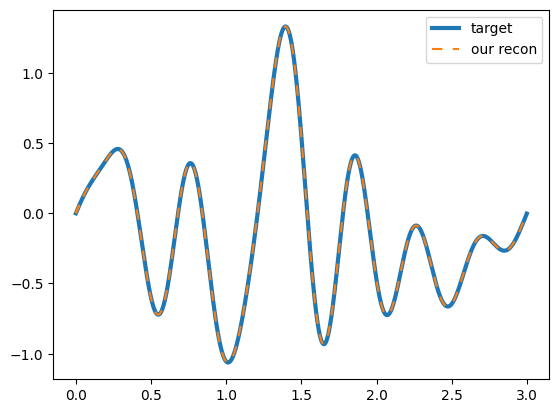

In [5]:
values = np.arange(0.0, 3, 1e-3)
plt.plot(values[-len(u[0]):], u[0], label='target',linewidth=3,)
plt.plot(values[-len(our_recon[0][:,-1,0]):], our_recon[0][:,-1,0], linestyle='-', label='our recon', dashes=(5, 5))
plt.legend()

### Visualisation 2 batch dimension

In [15]:
vals = np.arange(0.0, 3, 1e-3)
np.random.seed(1)
our_hippo = HIPPO_LEGS(N=64, gbt_alpha=0.5, maxlength=3000)
u = whitesignal(3, 1e-3, 3.0, batch_shape=(2,))
coeffs, our_recon = our_hippo(u)
our_recon = our_recon

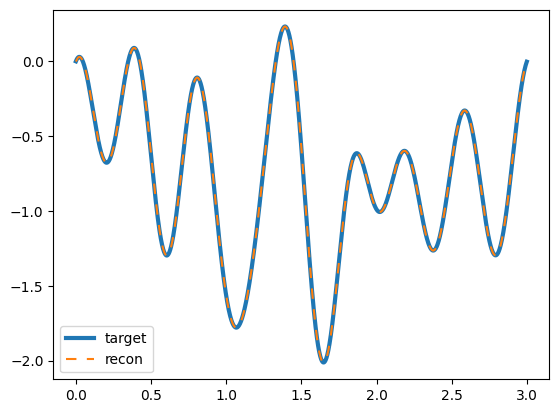

In [16]:
values = np.arange(0.0, 3, 1e-3)
plt.plot(values[-len(u[0]):], u[0], label='target',linewidth=3,)
plt.plot(values[-len(our_recon[0][-1,:,0]):], our_recon[0][-1,:,0], linestyle='-', label='recon', dashes=(5, 5))
plt.legend()

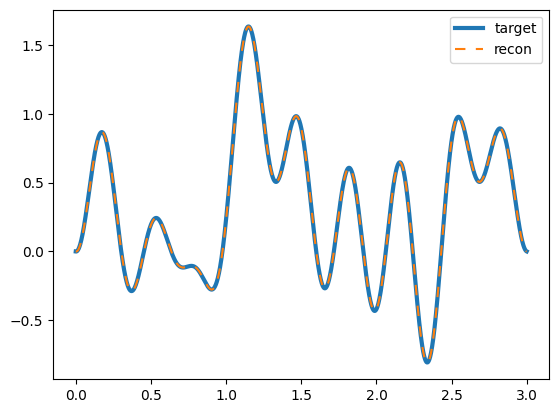

In [17]:
values = np.arange(0.0, 3, 1e-3)
plt.plot(values[-len(u[1]):], u[1], label='target',linewidth=3,)
plt.plot(values[-len(our_recon[1][-1,:,0]):], our_recon[1][-1,:,0], linestyle='--', label='recon', dashes=(5, 5))
plt.legend()

### Train base HiPPO


In [21]:
class HippoLegsCell(nn.Module):
    '''
    Hippo class utilizing legs polynomial
    '''

    def __init__(self, N, gbt_alpha = 0.5, maxlength = 1024, reconst = False):
        super(HippoLegsCell, self).__init__()
        self.N = N
        self.gbt_alpha = gbt_alpha
        self.maxlength = maxlength
        A, self._B = self.get_A_and_B(N = self.N)
        GBTA, GBTB = self.get_stacked_GBT(A = A, B = self._B)
        self.A = torch.from_numpy(GBTA).to(device)
        self.B = torch.from_numpy(GBTB).to(device)
        self.reconst = reconst

    def compute_A(self, n, k):
        '''
        Computes the values for the HiPPO A matrix row by column
        using the piecewise equation on p. 31 eq. 29:
                (2n+1)^{1/2} (2k+ 1)^{1/2} if n > k
        A_{nk} = n+1                       if n = k,
                 0                         if n < k
        , where n represents the row and k the columns.

        Input:
            n (int):
                nth row of a square matrix of size N
            k (int):
                kth column of a square matrix of size N

        Output:
            Values (float):
            Individual values for the elements in the A matrix.
        '''
        if n > k:
            val = np.sqrt(2 * n + 1, dtype = np.float32) * np.sqrt(2 * k + 1, dtype = np.float32)
        if n == k:
            val = n + 1
        if n < k:
            val = 0
        return val

    def compute_B(self, n):
        '''
        Computes the values for the HiPPO B matrix row by column
        using the piecewise equation on p. 31 eq. 29:
        B_{n} = (2n+1)^{1/2}

        Input:
            n (int):
                nth column of a square matrix of size N.

        Output:
            Values (float):
            Individual values for the elements in the B matrix.
            The next hidden state (aka coefficients representing the function, f(t))
        '''
        val = np.sqrt(2 * n + 1, dtype = np.float32)
        return val

    def get_A_and_B(self, N):
        '''
        Creates the HiPPO A and B matrix given the size N along a single axis of
        a square matrix.

        Input:
            N (int):
            Size N of a square matrix along a single axis.

        Output:
            A (np.ndarray)
                shape: (N,N)
                the HiPPO A matrix.
            B (np.ndarray)
                shape: (N,):
                The HiPPO B matrix.
        '''
        A = np.zeros((self.N, self.N), dtype = np.float32)
        B = np.zeros((self.N, 1), dtype = np.float32)
        for n in range(A.shape[0]):
            B[n][0] = self.compute_B(n = n)
            for k in range(A.shape[1]):
                A[n, k] = self.compute_A(n = n , k = k)
        return A  * -1, B

    def generalized_bilinear_transform(self, A, B, t, gbt_alpha):
        '''
        Performs the generalised bilinaer transform from p. 21 eq.13:
        c(t + ∆t) − ∆tαAc(t + ∆t) = (I + ∆t(1 − α)A)c(t) + ∆tBf(t)
        c(t + ∆t) = (I − ∆tαA)^{−1} (I + ∆t(1 − α)A)c(t) + ∆t(I − ∆tαA)^{−1}Bf(t).
        on the HiPPO matrix A and B, transforming them.
        Input:
            A (np.ndarray):
                shape: (N, N)
                the HiPPO A matrix
            B (np.ndarray):
                shape: (N,)
                the HiPPO B matrix
            Timestep t = 1/input length at t (int):

        Output:
            GBTA (np.array):
                shape: (N, N)
                Transformed HiPPO A matrix.

            GBTB (np.array):
                shape: (N,)
                Transformed HiPPO B matrix.
        '''
        I = np.eye(A.shape[0], dtype = np.float32)
        delta_t = 1 / t
        EQ13_p1 = I - (delta_t * gbt_alpha * A)
        EQ13_p2 = I + (delta_t * (1 - gbt_alpha) * A)
        EQA = np.linalg.solve(EQ13_p1, EQ13_p2)
        EQB =  np.linalg.solve(EQ13_p1, (delta_t * B))
        return EQA, EQB

    def get_stacked_GBT(self, A, B):
        GBTA_stacked = np.empty((self.maxlength, self.N, self.N), dtype=np.float32)
        GBTB_stacked = np.empty((self.maxlength, self.N, 1), dtype=np.float32)
        for t in range(1, self.maxlength + 1):
            GBTA, GBTB = self.generalized_bilinear_transform(A = A, B = B, t = t, gbt_alpha = self.gbt_alpha)
            GBTA_stacked[t-1] = GBTA
            GBTB_stacked[t-1] = GBTB
        return GBTA_stacked, GBTB_stacked


    def reconstruct(self, c, B):
        '''
        Input:
            c (np.ndarray): 2, 1, 32
                shape: (batchsize, 1, N_coeffs)
                coefficent matrix
            B (np.ndarray):
                shape: (N, 1)
                the discretized B matrix
        Returns:
            recon (np.ndarray):
                shape: (batchsize, maxlength, 1)
                Reconstruction matrix.
        '''
        with torch.no_grad():
            vals = np.linspace(0.0, 1.0, self.maxlength)
            # c shape from: [batchsize, 1, N_coeffs]
            # move to: [batchsize, N_coeffs, 1]
            c = torch.moveaxis(c, 1, 2).float()
            eval_mat = (self._B * np.float32(ss.eval_legendre(np.expand_dims(np.arange(self.N, dtype = np.float32), -1), 2 * vals - 1))).T
            # shape: B :-: (N, 1)
            # shape: eval_mat :-:  (maxlen, N)
            recon = (torch.tensor(eval_mat).to(device) @ c.to(device))
            # shape: recon :-: (batchsize, maxlength, 1
            return recon

    def forward(self, input, c_t = None, t = 0):
        '''
        Input:
            A (np.ndarray):
                shape: (N, N)
                the discretized A matrix
            B (np.ndarray):
                shape: (N, 1)
                the discretized B matrix
            c_t (np.ndarray): 2, 1, 32
                shape: (batch size, 1, N)
                the initial hidden state
            input (torch.tensor):
                shape: (batch size, 1 ,1)
                the input sequence
        Output:
            c (np.array):
                shape: (batch size, 1, N)
                coefficent matrix c.
        '''
        batchsize = input.shape[0]
        L = input.shape[1]
        if c_t is None:
            c_t = torch.zeros((batchsize, 1, self.N)).to(device)
        c_t = F.linear(c_t.float(), self.A[t]).float() + self.B[t].squeeze(-1) * input
        # shape: F.linear(torch.tensor(c_t).float(), torch.tensor(A[t])) :-: (batchsize, 1, N)
        # shape: (np.squeeze(B[t], -1) * f_t.numpy()).shape) :-: (batchsize, 1, N)
        # shape: A[t] :-: (N, N)
        # shape: torch.squeeze(B[t], -1) :-: (N, )
        # shape: f_t :-: (batchsize, 1, 1)
        # shape: c_t :-: (batchsize, 1, N)
        if self.reconst:
            # 3. Compute reconstruction r
            r =  self.reconstruct(c = c_t, B = self._B)
        else:
            r = 0
        return c_t, r

### Hippo Pred Net

In [22]:
class Hippo_Net(nn.Module):
    def __init__(self, N, gbt_alpha = 0.5, maxlength = 1024, reconst = False, output_size = 10):
        super(Hippo_Net, self).__init__()
        self.hippo_cell_t = HippoLegsCell(N = N, gbt_alpha = gbt_alpha, maxlength = maxlength, reconst = reconst)
        self.mlp = nn.Linear(N, output_size)
        self.N = N

    def forward(self, inputs, c_t = None):
        if c_t is None:
            c_t = torch.zeros(inputs.shape[1], 1, self.N).to(device)
        for t, f_t in enumerate(inputs):
            c_t, rec = self.hippo_cell_t(input = f_t, c_t = c_t, t = t)
            # shape c_t :-: (batchsize, 1, N)
            # squeeze singleton dim at index 1 for mlp input
        mlp_out = self.mlp(c_t.squeeze(1).float())
        return mlp_out, rec

### Test Hippo LegS Cell

In [25]:
vals = np.arange(0.0, 3, 1e-3)
np.random.seed(1)
our_hippo = Hippo_Net(N=32, maxlength = 3000, reconst = True).to(device)
u = torch.tensor(whitesignal(3, 1e-3, 3.0, batch_shape=(2,)))
inputs = u.T.unsqueeze(-1).unsqueeze(-1)
inputs = inputs.detach().to(device)
outs, our_recon = our_hippo(inputs)

### Visualisation 2 batch dimension


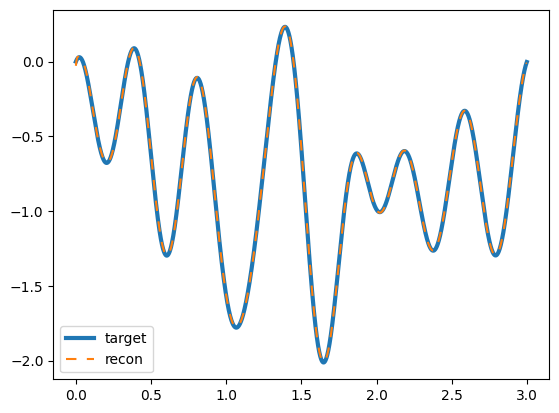

In [26]:
values = np.arange(0.0, 3, 1e-3)
plt.plot(values[-len(u[0]):], u[0], label='target',linewidth=3,)
plt.plot(values[-len(our_recon[0].cpu()):], our_recon[0].cpu(), linestyle='--', label='recon', dashes=(5, 5))
plt.legend()

### Visualise second batch

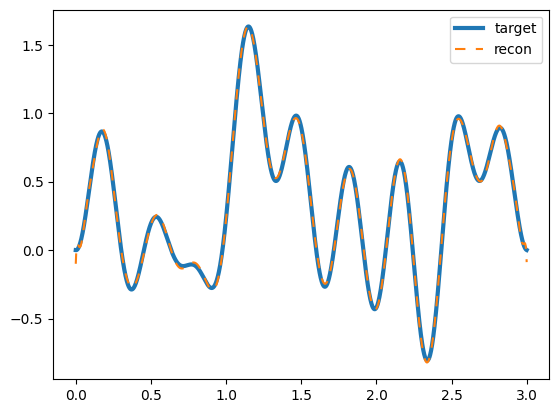

In [27]:
values = np.arange(0.0, 3, 1e-3)
plt.plot(values[-len(u[1]):], u[1], label='target',linewidth=3,)
plt.plot(values[-len(our_recon[1].cpu()):], our_recon[1].cpu(), linestyle='--', label='recon', dashes=(5, 5))
plt.legend()

### Train Hippo Net

In [28]:
def top1accuracy(class_prob, target):
    """
    Calculates top 1 accuracy.
    Input: Class probabilities from the neural network (tensor)
    and target class predictions (tensor) of shape number of classes by batch size
    Output: Top 1 accuracy (float).
    """
    with torch.no_grad():
        pred_class = torch.argmax(class_prob, dim = 1)
        top1_acc = sum(target==pred_class) / len(target)
    return top1_acc

def top5accuracy(class_prob, target):
    """
    Calculates top 1 accuracy.
    Input: Output of class probabilities from the neural network (tensor)
    of shape number of classes by batch size.
    Output: Top 5 accuracy (float).
    """
    with torch.no_grad():
        _, top5_class_pred = class_prob.topk(5, 1, largest = True, sorted = True)
        top5_class_pred = top5_class_pred.t()
        target_reshaped = target.view(1, -1).expand_as(top5_class_pred)
        correct = (top5_class_pred == target_reshaped)
        ncorrect_top5 = 0
        for i in range(correct.shape[1]):
            if (sum(correct[:,i]) >= 1):
                ncorrect_top5 = ncorrect_top5 + 1
        top5_acc = ncorrect_top5 / len(target)
        return top5_acc


In [29]:
def train (data_loader, model, optimizer, loss_f):
    """
    Input: train loader (torch loader), model (torch model), optimizer (torch optimizer)
          loss function (torch custom yolov1 loss).
    Output: loss (torch float).
    """
    loss_lst = []
    top1_acc_lst = []
    top5_acc_lst = []
    model.train()
    for batch_idx, (x, y) in enumerate(data_loader):
        x, y = x.to(device), y.to(device)
        x = x.T.unsqueeze(-1).unsqueeze(-1).to(device)
        out, rec = model(x)
        del x
        class_prob = F.softmax(out, dim = 1)
        pred = torch.argmax(class_prob, dim = 1)
        loss_val = loss_f(class_prob, y)
        loss_lst.append(float(loss_val.item()))
        top1_acc_val = top1accuracy(class_prob, y)
        top5_acc_val = top5accuracy(class_prob, y)
        top1_acc_lst.append(float(top1_acc_val))
        top5_acc_lst.append(float(top5_acc_val))
        del y, out
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        del loss_val

    # compute average loss
    loss_val = round(sum(loss_lst) / len(loss_lst), 4)
    top1_acc = round(sum(top1_acc_lst) / len(top1_acc_lst),  4)
    top5_acc = round(sum(top5_acc_lst) / len(top5_acc_lst), 4)
    return (loss_val, top1_acc, top5_acc)

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 64
weight_decay = 0.0
epochs = 5
nworkers = 2
lr = 1e-3
pin_memory = True
data_dir =  'data/'

train_dataset = datasets.MNIST(root = data_dir,
                                                train = True,
                                                transform = T.Compose([T.ToTensor(), T.Lambda(torch.flatten)]),
                                                download = True)
train_loader = DataLoader(dataset = train_dataset,
                                            batch_size = batch_size,
                                            shuffle = True, drop_last = True)


model = Hippo_Net(N=32, maxlength = 28*28, output_size = 10).to(device)
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)
loss_f = nn.CrossEntropyLoss()
for epoch in range(epochs):
    train_loss_value, train_top1acc_value, train_top5acc_value = train(train_loader, model, optimizer, loss_f)

    print(f"Epoch:{epoch + 1}   Train[Loss:{train_loss_value} Top1 Acc:{train_top1acc_value}  Top5 Acc:{train_top5acc_value}]")

100%|██████████| 9912422/9912422 [00:00<00:00, 104385526.24it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 38273520.96it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32049917.26it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6365027.99it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Epoch:1   Train[Loss:2.296 Top1 Acc:0.2547  Top5 Acc:0.6717]


KeyboardInterrupt: ignored